In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from joblib import dump, load

In [6]:
filename = "INFY"
timeframe = 5

In [7]:
columns_to_drop = ["atr","rsi","sma_50","sma_200","sma_20","uptrend","support","resistance"]

In [8]:
df = pd.read_csv(f"./raw_data_for_machine_learning/{filename}.csv").set_index("datetime").drop(columns=columns_to_drop)
df.index = pd.to_datetime(df.index)

<Axes: xlabel='datetime'>

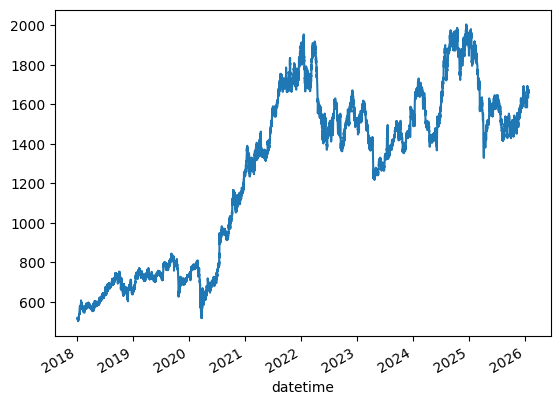

In [9]:
df["close"].plot()

In [10]:
df['ml_target'].isna().value_counts()

ml_target
True     148147
False      1094
Name: count, dtype: int64

In [11]:
df['ml_target_short'].isna().value_counts()

ml_target_short
True     148616
False       625
Name: count, dtype: int64

#### Feature Engineering

##### Calculating Support and resistance

In [12]:
df["resistance"] = df["close"].shift().rolling(10).max() 
df["support"]    = df["close"].shift().rolling(10).min() 

##### Calculating Technical Indicators

In [13]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                  abs(x['high'] - x['prev_close']), 
                  abs(x['low'] - x['prev_close'])), axis=1
)
df['atr'] = df['tr'].shift().rolling(14).mean()

    Time of the day feature

In [14]:
# Option 3: Session Progress and Position-Based Features
df["hour"] = df.index.hour
# First, let's define market hours in minutes
market_open_minutes = 9 * 60 + 15  # 9:15 AM = 555 minutes from midnight
market_close_minutes = 15 * 60 + 30  # 3:30 PM = 930 minutes from midnight
total_trading_minutes = market_close_minutes - market_open_minutes  # 375 minutes (6h 15min)

# Get current time in minutes from midnight
df['current_minutes'] = df['hour'] * 60 + pd.to_datetime(df.index).minute

# Calculate session progress (0 at open, 1 at close)
df['session_progress'] = (df['current_minutes'] - market_open_minutes) / total_trading_minutes

# Create binary flags for early and late sessions
df['is_early_session'] = (df['session_progress'] < 0.33).astype(int)  # First ~2 hours
df['is_late_session'] = (df['session_progress'] > 0.67).astype(int)   # Last ~2 hours

# Optional: You can drop the intermediate 'current_minutes' column if you don't need it
# df = df.drop('current_minutes', axis=1)

    Intrabar volatility

In [15]:
df['hl_ratio'] = (
    (df['high'].shift(1) - df['low'].shift(1)) / df['close'].shift(1)
)   #This comes from previous candle


    Price positioning feature

In [16]:
df['open_to_support_dist'] = (df['open'] - df['support']) / df['open']

    Volume

In [17]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].shift().rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"].shift() / df["volume_ma"]

    RSI

In [18]:
def calculate_rsi(data, period=14):
    delta = data.diff().shift(1)  # ✓ Shift after diff
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = calculate_rsi(df["close"], period=14)

    MACD

In [19]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    shifted_data = data.shift(1)
    ema_fast = shifted_data.ewm(span=fast, adjust=False).mean()
    ema_slow = shifted_data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize by PREVIOUS close (not current)
df["macd_norm"] = df["macd"] / df["close"].shift(1)
df["macd_hist_norm"] = df["macd_hist"] / df["close"].shift(1)

    Moving Averages

In [20]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].shift().rolling(5).mean()
df["10ma"] = df["close"].shift().rolling(10).mean()
df["50ma"] = df["close"].shift().rolling(50).mean()
df["200ma"] = df["close"].shift().rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"].shift()
df["close_5ma_diff_pct"] = (df["close"].shift() - df["5ma"]) / df["close"].shift()
df["close_10ma_diff_pct"] = (df["close"].shift() - df["10ma"]) / df["close"].shift()
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"].shift()

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"].shift() - df["50ma"]) / df["close"].shift()
df["close_200ma_diff_pct"] = (df["close"].shift() - df["200ma"]) / df["close"].shift()

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


    Pressure Features

In [21]:
df["volume_pressure_prev"] = (
    df["close"].shift(1) - df["open"].shift(1)
) / df["volume"].shift(1)
df["range_per_volume_prev"] = (
    df["high"].shift(1) - df["low"].shift(1)
) / df["volume"].shift(1)


    Gap Pressure

In [22]:
df["gap_pct"] = (
    df["open"] - df["close"].shift(1)
) / df["close"].shift(1)


    Candle type

In [23]:
df["candle_type"] = (df["close"].shift() - df["open"].shift())/(df["high"].shift()-df["low"].shift())   
df["candle_type_lag1"] = df["candle_type"].shift(1)  # Previous candle
df["candle_type_lag2"] = df["candle_type"].shift(2)  # 2 candles ago


    Support and Resistance difference percentage

In [24]:
# Open's position relative to S/R levels
df['open_above_resistance'] = (
    ((df['open'] - df['resistance']) / df['atr']).shift(1)
)
df['open_below_support'] = (
    ((df['support'] - df['open']) / df['atr']).shift(1)
)

# Or combined - where is open in the S/R range?
df['open_sr_position'] = (
    ((df['open'] - df['support']) / (df['resistance'] - df['support']))
).shift(1)  # 0 = at support, 1 = at resistance, >1 = above, <0 = below

# S/R range width (how wide is the channel?)
df['sr_range_atr'] = (
    ((df['resistance'] - df['support']) / df['atr']).shift(1)
)

    Breakout Features

In [25]:
# Strength
df['resistance_breakout_strength'] = (
    ((df['close'] - df['resistance']) / df['atr']).clip(lower=0).shift(1)
)
df['support_breakdown_strength'] = (
    ((df['support'] - df['close']) / df['atr']).clip(lower=0).shift(1)
)
# Conviction
rng = (df['high'] - df['low']).replace(0, np.nan)
df['resistance_breakout_conviction'] = (
    ((df['close'] - df['resistance']) / rng).clip(-1, 1).shift(1)
)
df['support_breakdown_conviction'] = (
    ((df['support'] - df['close']) / rng).clip(-1, 1).shift(1)
)
# Volume
df['breakout_volume_ratio'] = (
    df['volume'] / df['volume'].rolling(20).mean()
).shift(1)
# Pressure / velocity
df['resistance_touch_count'] = (
    (df['high'].shift(1) >= df['resistance'].shift(1))
    .rolling(10).sum()
)
df['support_touch_count'] = (
    (df['low'].shift(1) <= df['support'].shift(1))
    .rolling(10).sum()
)

#### Target Creation

In [26]:
df['ml_target'] = np.where(
    df['ml_target'].isna(), 
    0,
    np.where(df['ml_target'] > 0, 1, -1)
)

df['ml_target_short'] = np.where(
    df['ml_target_short'].isna(), 
    0,
    np.where(df['ml_target_short'] > 0, 1, -1)
)


In [27]:
print(df['ml_target'].value_counts(dropna=False))
print(df['ml_target_short'].value_counts(dropna=False))


ml_target
 0    148147
 1       707
-1       387
Name: count, dtype: int64
ml_target_short
 0    148616
 1       436
-1       189
Name: count, dtype: int64


In [28]:
df['ml_target_combined'] = (
    df['ml_target']
    .where(df['ml_target'] != 0, df['ml_target_short'])
)


In [29]:
df['ml_target_combined'].value_counts()


ml_target_combined
 0    147522
 1      1143
-1       576
Name: count, dtype: int64

In [30]:
feature_and_target = [
    # Time-based features
    'hour',
    'session_progress',
    'is_early_session',
    'is_late_session',
    
    # Volatility features
    # 'atr',
    'hl_ratio',
    
    # Volume features
    'volume_ma',
    'volume_ratio',
    'volume_pressure_prev',
    'range_per_volume_prev',
    'breakout_volume_ratio',
    
    # Technical indicators
    'rsi_14',
    'macd',
    'macd_signal',
    'macd_hist',
    'macd_norm',
    'macd_hist_norm',
    
    # Moving averages (relative features)
    '5ma',
    '10ma',
    '50ma',
    '200ma',
    '5_10_ma_diff_pct',
    'close_5ma_diff_pct',
    'close_10ma_diff_pct',
    'golden_cross_pct',
    'close_50ma_diff_pct',
    'close_200ma_diff_pct',
    '5ma_roc',
    '50ma_roc',
    
    # Price gaps
    'gap_pct',
    
    # Candle patterns
    'candle_type',
    'candle_type_lag1',
    'candle_type_lag2',
    
    # Support/Resistance
    'resistance',
    'support',
    
    # Breakout features
    'resistance_breakout_strength',
    'support_breakdown_strength',
    'resistance_breakout_conviction',
    'support_breakdown_conviction',
    'resistance_touch_count',
    'support_touch_count',

    #Target

    "ml_target_combined"
]

In [31]:

df_feature_target = df[feature_and_target]
print(len(df_feature_target))
df_feature_target = df_feature_target.dropna(how="any")
print(len(df_feature_target))


149241
148981


In [32]:
df_feature_target = df_feature_target[
    (df_feature_target['ml_target_combined'] == -1) |
    (df_feature_target['ml_target_combined'] == 1)
]


In [33]:
X = df_feature_target.drop(columns="ml_target_combined")
y = df_feature_target["ml_target_combined"]

In [34]:
X.head()

,hour,session_progress,is_early_session,is_late_session,hl_ratio,volume_ma,volume_ratio,volume_pressure_prev,range_per_volume_prev,breakout_volume_ratio,...,candle_type_lag1,candle_type_lag2,resistance,support,resistance_breakout_strength,support_breakdown_strength,resistance_breakout_conviction,support_breakdown_conviction,resistance_touch_count,support_touch_count
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-05 14:30:00+05:30,14,0.840000,0,1,0.000790,20523.75,0.938328,-0.000006,0.000021,0.938328,...,0.555556,0.250000,506.15,505.80,0.0,0.0,-0.300000,-0.575000,10.0,6.0
2018-01-05 14:45:00+05:30,14,0.880000,0,1,0.000929,20612.30,0.702881,-0.000005,0.000032,0.702881,...,0.451613,-0.657143,506.15,505.80,0.0,0.0,-0.255319,-0.489362,10.0,6.0
2018-01-08 11:35:00+05:30,11,0.373333,0,0,0.002394,16323.90,0.645495,-0.000107,0.000117,0.645495,...,-0.200000,-0.086207,515.30,513.50,0.0,0.0,-1.000000,-0.268293,3.0,0.0
2018-01-09 10:50:00+05:30,10,0.253333,1,0,0.002769,57114.25,0.606959,-0.000003,0.000041,0.606959,...,0.183673,-0.214286,516.50,516.03,0.0,0.0,-0.377622,-0.244755,2.0,2.0
2018-01-10 09:50:00+05:30,9,0.093333,1,0,0.002305,45736.80,0.495050,-0.000017,0.000053,0.495050,...,0.913043,-0.734234,523.10,519.90,0.0,0.0,-1.000000,-0.583333,2.0,2.0


In [35]:
y.value_counts()

ml_target_combined
 1    1143
-1     575
Name: count, dtype: int64

#### Training the model

Train: 1294 (2018-01-05 14:30:00+05:30 to 2023-12-26 13:10:00+05:30)
Val: 218 (2024-01-03 11:35:00+05:30 to 2024-12-27 14:50:00+05:30)
Test: 206 (2025-01-02 14:20:00+05:30 to 2026-01-23 13:15:00+05:30)

Class distribution - Train:
ml_target_combined
 1    849
-1    445
Name: count, dtype: int64

Train score: 0.7002
Val score: 0.6514
Test score: 0.6553

Test Confusion Matrix:
[[ 23  36]
 [ 35 112]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.39      0.39        59
           1       0.76      0.76      0.76       147

    accuracy                           0.66       206
   macro avg       0.58      0.58      0.58       206
weighted avg       0.65      0.66      0.65       206


Best Val Accuracy: 0.6560 at depth 5


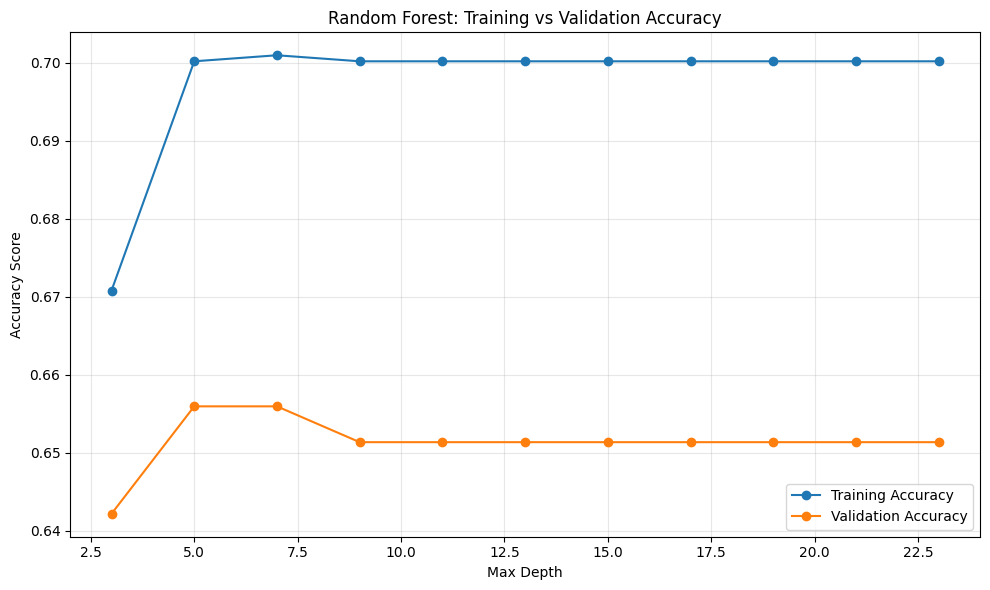

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [36]:
model_preparation(X,y)

In [37]:
model = best_model(X,y,max_depth=3) #7 for powergrid

Train score: 0.6754
Val score: 0.6468
Test score: 0.6602

Test Confusion Matrix:
[[ 22  37]
 [ 33 114]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.37      0.39        59
           1       0.75      0.78      0.77       147

    accuracy                           0.66       206
   macro avg       0.58      0.57      0.58       206
weighted avg       0.65      0.66      0.66       206



In [38]:
# dump(model, "adani_ports_1_min.joblib")

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
    
    # Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

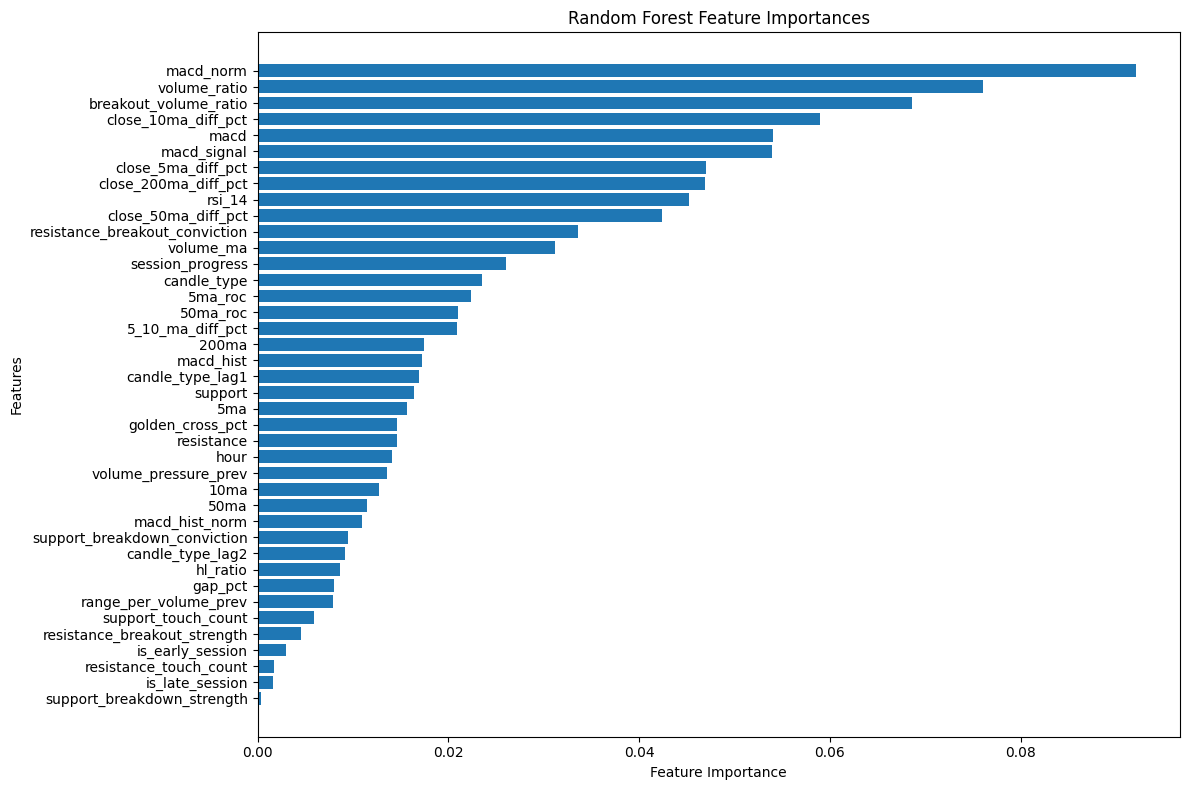

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=True)

# # Print top features
# print("Top 20 Most Important Features:")
# print(importance_df.head(20))

# Basic histogram
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


#### Applying Machine learning filter to strategy.

In [41]:
# df =pd.read_csv("./machine_learning_plus_trading/ADANIPORTS_2018_2025.csv").set_index('datetime')
# df.index = pd.to_datetime(df.index)
# df.head()

#### Adding Model to the strategy

In [42]:
feature_and_target = [
    # Time-based features
    'hour',
    'session_progress',
    'is_early_session',
    'is_late_session',
    
    # Volatility features
    # 'atr',
    'hl_ratio',
    
    # Volume features
    'volume_ma',
    'volume_ratio',
    'volume_pressure_prev',
    'range_per_volume_prev',
    'breakout_volume_ratio',
    
    # Technical indicators
    'rsi_14',
    'macd',
    'macd_signal',
    'macd_hist',
    'macd_norm',
    'macd_hist_norm',
    
    # Moving averages (relative features)
    '5ma',
    '10ma',
    '50ma',
    '200ma',
    '5_10_ma_diff_pct',
    'close_5ma_diff_pct',
    'close_10ma_diff_pct',
    'golden_cross_pct',
    'close_50ma_diff_pct',
    'close_200ma_diff_pct',
    '5ma_roc',
    '50ma_roc',
    
    # Price gaps
    'gap_pct',
    
    # Candle patterns
    'candle_type',
    'candle_type_lag1',
    'candle_type_lag2',
    
    # Support/Resistance
    'resistance',
    'support',
    
    # Breakout features
    'resistance_breakout_strength',
    'support_breakdown_strength',
    'resistance_breakout_conviction',
    'support_breakdown_conviction',
    'resistance_touch_count',
    'support_touch_count',

]


df = df.dropna(subset=feature_and_target).copy()


df["y_pred"] = model.predict(df[feature_and_target])
y_predict_probability = model.predict_proba(df[feature_and_target])

#### Recreating Strategy

In [43]:
df

,open,high,low,close,volume,ml_target,ml_target_short,resistance,support,prev_close,...,sr_range_atr,resistance_breakout_strength,support_breakdown_strength,resistance_breakout_conviction,support_breakdown_conviction,breakout_volume_ratio,resistance_touch_count,support_touch_count,ml_target_combined,y_pred
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-03 14:20:00+05:30,511.00,511.40,510.53,511.03,16671,0,0,511.5,510.25,511.00,...,2.147239,0.000000,0.000000,-0.714286,-1.000000,0.662945,5.0,2.0,0,1
2018-01-03 14:25:00+05:30,511.03,511.08,510.60,510.78,14803,0,0,511.5,510.25,511.03,...,2.095808,0.000000,0.000000,-0.540230,-0.896552,0.851654,5.0,2.0,0,1
2018-01-03 14:30:00+05:30,510.80,511.05,510.00,510.23,36254,0,0,511.5,510.25,510.78,...,2.023121,0.000000,0.000000,-1.000000,-1.000000,0.768462,4.0,2.0,0,1
2018-01-03 14:35:00+05:30,510.23,510.70,509.68,509.80,28281,0,0,511.5,510.23,510.23,...,2.034884,0.000000,0.032558,-1.000000,0.019048,1.755901,4.0,3.0,0,1
2018-01-03 14:40:00+05:30,509.80,510.35,509.30,510.00,24471,0,0,511.5,509.80,509.80,...,1.907725,0.000000,0.645923,-1.000000,0.421569,1.321622,3.0,4.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23 15:10:00+05:30,1671.70,1671.90,1668.50,1668.70,196000,0,0,1671.6,1662.90,1671.60,...,3.207430,0.563467,0.000000,0.684211,-1.000000,2.554889,6.0,2.0,0,1
2026-01-23 15:15:00+05:30,1668.70,1670.20,1668.30,1670.20,237920,0,0,1671.6,1663.40,1668.70,...,3.759259,0.000000,0.000000,-0.852941,-1.000000,2.152630,7.0,1.0,0,1
2026-01-23 15:20:00+05:30,1670.10,1671.20,1669.70,1670.70,248120,0,0,1671.6,1665.90,1670.20,...,3.327536,0.000000,0.000000,-0.736842,-1.000000,2.377369,7.0,0.0,0,1


In [44]:
# Calculate RSI (14-period standard)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI
df['rsi'] = calculate_rsi(df['close'], period=14).shift()  # shift to avoid lookahead


In [45]:
# Add simple trend filter
df['sma_50'] = df['close'].shift().rolling(50).mean()
df['sma_200'] = df['close'].shift().rolling(200).mean()
df["sma_20"] = df["close"].shift().rolling(20).mean() 

# Uptrend: price > SMA50 > SMA200
df['uptrend'] = (
                 (df['sma_50'] > df['sma_200']) &
                 (df["close"]>df["sma_20"])
                 ).astype(int)

df["downtrend"] = ( 
                 (df['sma_50']< df['sma_200']) &
                 (df["close"]<df["sma_20"])
                 ).astype(int)


##### Creating Long positions

In [46]:
df['entry_signal'] = (
    (df['low'] <= df['support']) &
    (df['rsi'] > 35) &
    (df['rsi'] < 55) &
    (df['uptrend'] == 1)
).astype(int)


In [47]:
df["entry_price"] = np.where(df["entry_signal"]==1, df["support"], np.nan)
df["target_price"] = np.where(df["entry_signal"]==1, df["resistance"], np.nan )

df["stop_loss_price"] = np.where(df["entry_signal"]==1, df["entry_price"]-(1 * df["atr"]), np.nan)

In [48]:
#INitializing trade pnl logic
df["trade_pnl"] = 0.0
df["exit_reason"] = ''
df["in_position"] = 0
trade_pnls = []
starting_capital = df.iloc[0]['close']
# starting_capital = 10000


entry_price = np.nan
stop_price = np.nan
target_price = np.nan
in_trade = False
TRANSACTION_COST = 0.0002

#For machine Learning
entry_index = None
df["ml_target"] =  np.nan
df["holding_period"] = np.nan

In [49]:
for i in range(len(df)):
    idx = df.index[i]

    #Mark if we are in position in this bar

    df.loc[idx, "in_position"] = 1 if  in_trade else 0


    #Exit logic first

    if in_trade:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        #Exit conditions
        if current_low<= stop_price:
            exit_price = stop_price
            exit_reason = "STOP" 
        elif current_high >= target_price:
            exit_price = target_price
            exit_reason = "TARGET"
        else:
            exit_price = None
        #Calculating PNL
        if exit_price is not None:
            pnl_per_share_gross = exit_price - entry_price
            
            #Calculating transaction cost
            cost_entry_per_share = entry_price * TRANSACTION_COST
            cost_exit_per_share = exit_price * TRANSACTION_COST
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            # Calculate position size
           
            # position_value = starting_capital * 2.5 
            # shares = position_value/entry_price
            # if df.loc[entry_index,'y_pred'] == 1:
            #     shares = 1.5
            # else:
            #     shares = 1 
            shares = 1.5

            #Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls.append(pnl_total_net)

            # Assign to dataframe at exit bar

            df.loc[idx, 'trade_pnl'] =  pnl_total_net
            df.loc[idx, 'exit_reason'] = exit_reason
            # Use percentage return (comparable across stocks):
            df.loc[entry_index, 'ml_target'] = (pnl_per_share_net / entry_price) * 100
            df.loc[entry_index, "holding_period"] = i - df.index.get_loc(entry_index)


            #Reset state

            in_trade = False
            entry_price = np.nan
            stop_price = np.nan
            target_price = np.nan
    
    #Entry logic
    elif df.loc[idx, "entry_signal"] == 1:
        in_trade = True
        entry_price = df.loc[idx, "entry_price"]
        stop_price = df.loc[idx, "stop_loss_price"]
        target_price = df.loc[idx, "target_price"]

        entry_index = idx

In [50]:
np.sum(trade_pnls)

np.float64(1666.0939892142862)

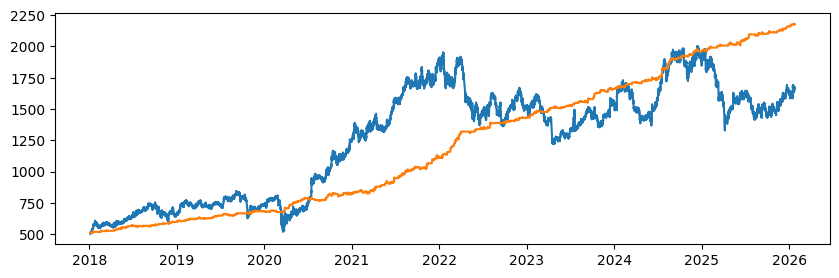

In [51]:
df["cumulative_pnl"] = df["trade_pnl"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

##### Creating Short positions

In [52]:
df['entry_signal_short'] = (
    (df['high'] >= df['resistance']) &
    (df['rsi'] > 50) &  # Price showing strength/overbought
    (df['rsi'] < 70)   # But not extremely overbought
    & (df['downtrend'] == 1)
).astype(int)

In [53]:
# Entry at close when price touches resistance
df["entry_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["resistance"], 
                                    np.nan)

In [54]:

df["target_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["support"],  # or df["close"] - (2 * df["atr"])
                                    np.nan)

# Stop ABOVE entry (correct - you have this right!)
df["stop_loss_price_short"] = np.where(df["entry_signal_short"]==1, 
                                       df["entry_price_short"] + (1 * df["atr"]), 
                                       np.nan)

In [55]:
# Initializing trade pnl logic for SHORTS
df["trade_pnl_short"] = 0.0
df["exit_reason_short"] = ''
df["in_position_short"] = 0
trade_pnls_short = []
starting_capital_short = df.iloc[0]['close']
# starting_capital_short = 10000

entry_price_short = np.nan
stop_price_short = np.nan
target_price_short = np.nan
in_trade_short = False
TRANSACTION_COST_SHORT = 0.0002  # Consider if shorts have higher costs

# For machine learning
entry_index_short = None
df["ml_target_short"] = np.nan
df["holding_period_short"] = np.nan

In [56]:
for i in range(len(df)):
    idx = df.index[i]

    # Mark if we are in position in this bar
    df.loc[idx, "in_position_short"] = 1 if in_trade_short else 0

    # Exit logic first
    if in_trade_short:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        # Exit conditions (INVERTED for shorts)
        if current_high >= stop_price_short:  # Stop hit when price goes UP
            exit_price = stop_price_short
            exit_reason = "STOP" 
        elif current_low <= target_price_short:  # Target hit when price goes DOWN
            exit_price = target_price_short
            exit_reason = "TARGET"
        else:
            exit_price = None
            
        # Calculating PNL
        if exit_price is not None:
            # INVERTED: profit when exit < entry for shorts
            pnl_per_share_gross = entry_price_short - exit_price  
            
            # Calculating transaction cost
            cost_entry_per_share = entry_price_short * TRANSACTION_COST_SHORT
            cost_exit_per_share = exit_price * TRANSACTION_COST_SHORT
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            # Calculate position size
           
            # position_value = starting_capital 
    
            # shares = position_value / entry_price_short
            
            # if df.loc[entry_index,'y_pred'] == 1:
            #     shares = 1.5
            # else:
            #     shares = 1 
            shares = 1.5

            # Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls_short.append(pnl_total_net)

            # Assign to dataframe at exit bar
            df.loc[idx, 'trade_pnl_short'] = pnl_total_net
            df.loc[idx, 'exit_reason_short'] = exit_reason
            
            # Use percentage return (comparable across stocks):
            df.loc[entry_index_short, 'ml_target_short'] = (pnl_per_share_net / entry_price_short) * 100
            df.loc[entry_index_short, "holding_period_short"] = i - df.index.get_loc(entry_index_short)

            # Reset state
            in_trade_short = False
            entry_price_short = np.nan
            stop_price_short = np.nan
            target_price_short = np.nan
    
    # Entry logic
    elif (df.loc[idx, "entry_signal_short"] == 1) and (not in_trade_short):

        in_trade_short = True
        entry_price_short = df.loc[idx, "entry_price_short"]
        stop_price_short = df.loc[idx, "stop_loss_price_short"]
        target_price_short = df.loc[idx, "target_price_short"]
        
        entry_index_short = idx

In [57]:
np.sum(trade_pnls_short)

np.float64(1033.8723120000025)

In [58]:
df["trade_pnl_total"] = df["trade_pnl"].fillna(0) + df["trade_pnl_short"].fillna(0)


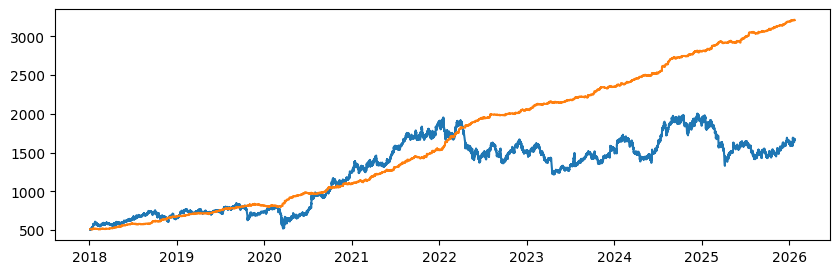

In [59]:
df["cumulative_pnl"] = df["trade_pnl_total"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

In [60]:
df

,open,high,low,close,volume,ml_target,ml_target_short,resistance,support,prev_close,...,equity_curve,entry_signal_short,entry_price_short,target_price_short,stop_loss_price_short,trade_pnl_short,exit_reason_short,in_position_short,holding_period_short,trade_pnl_total
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-03 14:20:00+05:30,511.00,511.40,510.53,511.03,16671,NaN,NaN,511.5,510.25,511.00,...,511.030000,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2018-01-03 14:25:00+05:30,511.03,511.08,510.60,510.78,14803,NaN,NaN,511.5,510.25,511.03,...,511.030000,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2018-01-03 14:30:00+05:30,510.80,511.05,510.00,510.23,36254,NaN,NaN,511.5,510.25,510.78,...,511.030000,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2018-01-03 14:35:00+05:30,510.23,510.70,509.68,509.80,28281,NaN,NaN,511.5,510.23,510.23,...,511.030000,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2018-01-03 14:40:00+05:30,509.80,510.35,509.30,510.00,24471,NaN,NaN,511.5,509.80,509.80,...,511.030000,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23 15:10:00+05:30,1671.70,1671.90,1668.50,1668.70,196000,NaN,NaN,1671.6,1662.90,1671.60,...,3210.996301,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2026-01-23 15:15:00+05:30,1668.70,1670.20,1668.30,1670.20,237920,NaN,NaN,1671.6,1663.40,1668.70,...,3210.996301,0,NaN,NaN,NaN,0.0,,0,NaN,0.0
2026-01-23 15:20:00+05:30,1670.10,1671.20,1669.70,1670.70,248120,NaN,NaN,1671.6,1665.90,1670.20,...,3210.996301,0,NaN,NaN,NaN,0.0,,0,NaN,0.0


In [61]:
trade_returns = df.loc[df['trade_pnl'] != 0, 'trade_pnl'] / 100
trade_returns

datetime
2018-01-09 10:55:00+05:30    0.003952
2018-01-10 10:05:00+05:30   -0.027147
2018-01-11 14:35:00+05:30    0.034722
2018-01-11 15:00:00+05:30   -0.023470
2018-01-12 12:30:00+05:30    0.005474
                               ...   
2026-01-14 12:25:00+05:30    0.009878
2026-01-19 13:25:00+05:30    0.048431
2026-01-19 15:30:00+05:30   -0.045969
2026-01-22 14:30:00+05:30    0.056057
2026-01-23 13:20:00+05:30   -0.036573
Name: trade_pnl, Length: 1093, dtype: float64

In [62]:
years = (df.index[-1] - df.index[0]).days / 365.25
trades_per_year = len(trade_returns) / years


In [63]:
sharpe = (
    trade_returns.mean() /
    trade_returns.std()
) * np.sqrt(trades_per_year)


In [64]:
sharpe

np.float64(3.3855737746190377)

In [65]:
win_rate = (trade_returns > 0).mean()
win_rate

np.float64(0.6477584629460201)

In [66]:
avg_win  = trade_returns[trade_returns > 0].mean()
avg_loss = trade_returns[trade_returns < 0].mean()
avg_loss,avg_win

(np.float64(-0.04072986716326548), np.float64(0.04568070444915265))

In [67]:
expectancy = trade_returns.mean()
expectancy

np.float64(0.015243311886681486)

In [68]:
equity = (1 + trade_returns).cumprod()


In [69]:
running_max = equity.cummax()
drawdown = equity / running_max - 1
max_dd = drawdown.min()
max_dd

np.float64(-0.2634141533344536)

In [70]:
total_return = equity.iloc[-1] - 1


In [71]:
years = (trade_returns.index[-1] - trade_returns.index[0]).days / 365.25
cagr = equity.iloc[-1] ** (1 / years) - 1


In [72]:
calmar = cagr / abs(max_dd)


In [73]:
metrics = {
    "cagr":cagr,
    "calmar": calmar,
    "total_return": total_return,
    "max_drawdown":max_dd,
    "cagr": cagr,
    "expectancy": expectancy,
    "average_loss": avg_loss,
    "average_win": avg_win,
    "sharpe": sharpe
}

In [74]:
metrics

{'cagr': np.float64(5.542008165247256),
 'calmar': np.float64(21.039143474612917),
 'total_return': np.float64(3605410.0706753167),
 'max_drawdown': np.float64(-0.2634141533344536),
 'expectancy': np.float64(0.015243311886681486),
 'average_loss': np.float64(-0.04072986716326548),
 'average_win': np.float64(0.04568070444915265),
 'sharpe': np.float64(3.3855737746190377)}

In [75]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ml_target',
       'ml_target_short', 'resistance', 'support', 'prev_close', 'tr', 'atr',
       'hour', 'current_minutes', 'session_progress', 'is_early_session',
       'is_late_session', 'hl_ratio', 'open_to_support_dist', 'volume_ma',
       'volume_ratio', 'rsi_14', 'macd', 'macd_signal', 'macd_hist',
       'macd_norm', 'macd_hist_norm', '5ma', '10ma', '50ma', '200ma',
       '5_10_ma_diff_pct', 'close_5ma_diff_pct', 'close_10ma_diff_pct',
       'golden_cross_pct', 'close_50ma_diff_pct', 'close_200ma_diff_pct',
       '5ma_roc', '50ma_roc', 'volume_pressure_prev', 'range_per_volume_prev',
       'gap_pct', 'candle_type', 'candle_type_lag1', 'candle_type_lag2',
       'open_above_resistance', 'open_below_support', 'open_sr_position',
       'sr_range_atr', 'resistance_breakout_strength',
       'support_breakdown_strength', 'resistance_breakout_conviction',
       'support_breakdown_conviction', 'breakout_volume_ratio',
       're

In [76]:
df.to_csv(f"./machine_learning_data/{filename}.csv", index="datetime")